In [28]:
import pandas as pd
import numpy as np
import math
import pennylane as qml
import random
import tensorflow as tf

## Brief Outline

The notebook will proceed in the following manner:

1. Brief description of Data
2. Defining QNN and using it to perform stock price prediction


## 1. Data

First, we read in the data, dropping the index and the date.

In [29]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop(['Unnamed: 0'], axis=1)
# df=df.drop(columns=['ARIMA'])
df=df[:100]

We identify the dependent and independent variables:

In [30]:
target = "Close"

In [31]:
features = list(df.columns.difference(["Close"]))
features

['ARIMA',
 'Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data Processing

To process the data, we first define few terms

In [32]:
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [33]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [34]:
df

,ARIMA,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,...,FT9,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume
0,0.012995,0.012995,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,0.029243,0.012995,1.411000,...,1.854712,2.592148,1.601011,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,0.430117
1,-0.696678,-0.696678,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-0.682508,-0.696678,0.828470,...,1.812925,2.161558,2.181198,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.143354
2,-1.757546,-1.757546,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-1.778908,-1.757546,0.828470,...,1.771162,2.161558,2.181198,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.276309
3,-1.453961,-1.453961,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-1.461052,-1.453961,0.994908,...,1.729429,1.730969,2.134977,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,0.319218
4,-0.547686,-0.547686,-1.729066,-2.049566,-2.052075,-1.415966,-2.052789,-0.531676,-0.547686,1.859786,...,1.687730,0.869790,1.457485,-0.571786,-0.128520,-0.647478,-3.151745,-2.052075,-1.015015,-0.090411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.378009,1.378009,0.112913,0.564471,0.549079,0.801435,0.534538,1.352645,1.378009,0.510457,...,-1.406991,-1.713745,-0.572560,1.153489,0.379173,1.258185,0.459923,0.549079,0.995527,1.970389
96,1.233497,1.233497,0.009253,0.576177,0.554918,0.565190,0.534991,1.215263,1.233497,0.266745,...,-1.428371,-1.713745,-0.778119,1.061804,0.130678,1.300059,0.464038,0.554918,0.996330,1.729874
97,1.350002,1.350002,-0.159000,0.592577,0.561766,0.669216,0.533074,1.326069,1.350002,0.266745,...,-1.449404,-1.713745,-0.778119,1.018244,0.009018,1.322279,0.469485,0.561766,0.997406,-0.715588
98,1.555007,1.555007,-0.243888,0.603879,0.568193,0.897878,0.535024,1.520061,1.555007,0.590703,...,-1.470087,-1.713745,-0.476471,1.048502,0.030010,1.347889,0.469107,0.568193,0.998336,1.402693


In [35]:
# Data for regression model
sequence_length_reg = window_reg =10 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(80, 10, 24) (80, 10)


In [36]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [37]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [38]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (72, 10, 24) and (72, 10)
Shape os test is (8, 10, 24) and (8, 10)


In [39]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(720, 24)
(720,)


In [40]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(80, 24)
(80,)


In [41]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg+1:len(df)- window_reg+1]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

# QNN

In [44]:
nqubits = 6
device = qml.device('default.qubit', wires=nqubits)
# Define QNode
@qml.qnode(device)
def qnode(inputs, weights): # inputs, weights, self.wires_update
#     inputs_ = [torch.arctan(feature) for feature in inputs]
    inputs_=inputs
    for p1,p2,p3,p4,p5,p6 in zip(weights[:5],weights[5:10],weights[10:15],weights[15:20],weights[20:25],weights[25:]):
        qml.Rot(*inputs_[:3], wires=0)
        qml.Rot(*inputs_[3:6], wires=1)
        qml.Rot(*inputs_[6:9], wires=2)
        qml.Rot(*inputs_[9:12], wires=3)
        qml.Rot(*inputs_[12:15], wires=4)
        qml.Rot(*inputs_[15:], wires=5)
        qml.Rot(*p1, wires=0)
        qml.Rot(*p2, wires=1)
        qml.Rot(*p3, wires=2)
        qml.Rot(*p4, wires=3)
        qml.Rot(*p5, wires=4)
        qml.Rot(*p6, wires=5)
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 4]) 
        qml.CNOT(wires=[4, 5])
        qml.CNOT(wires=[5, 0]) 
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

# define weight_shapes
weight_shapes = {"weights": (30, 3)}

In [45]:
from tensorflow.keras import regularizers, initializers
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Model

In [46]:
input_ = Input((24,)) # feature
den1=Dense(18, use_bias=True,activation='relu')(input_) 
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=nqubits)(den1)
den5=Dense(1, use_bias=True,activation='linear')(qlayer)
model = Model(inputs=[input_], outputs=den5)

In [47]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss=loss_fn)

In [48]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=5,  # total epoch
                   )

Epoch 1/5
23/23 [==============================] - 473s 21s/step - loss: 0.4416 - val_loss: 0.2971
Epoch 2/5
23/23 [==============================] - 580s 25s/step - loss: 0.1720 - val_loss: 0.1221
Epoch 3/5
23/23 [==============================] - 661s 29s/step - loss: 0.0762 - val_loss: 0.0669
Epoch 4/5
23/23 [==============================] - 682s 30s/step - loss: 0.0504 - val_loss: 0.0583
Epoch 5/5
23/23 [==============================] - 816s 36s/step - loss: 0.0386 - val_loss: 0.0541


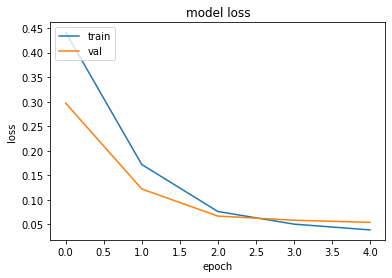

In [49]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

In [ ]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test : ',rmse_test_ann)

In [50]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_check_pred_qnn = model.predict(X_check_reg)
y_check_pred_qnn=y_check_pred_qnn.flatten()
mae_check_qnn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_qnn)
rmse_check_qnn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_qnn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_qnn)

Mean absolute Error :  59.5512988281248
Root Mean Squared Error :  98.52153712214302


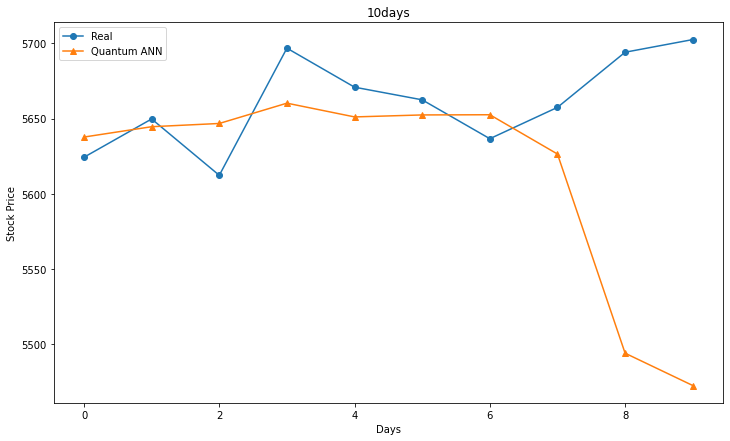

In [52]:
plt.figure(figsize=(12, 7))
plt.plot(y_check_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_qnn* target_stdev + target_mean, label = "Quantum ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window_reg)+'days')
plt.legend()
plt.show()

In [53]:
save_data=[y_check_reg* target_stdev + target_mean,
          y_check_pred_qnn* target_stdev + target_mean]

In [54]:
import csv 
# name of csv file   
filename = "QNN_result_code.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)